# Realtime Multi-Person 2D Pose Estimation using Part Affinity Fields

## Import the Libraries

In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import YouTubeVideo, display, Image

%matplotlib inline

## Highlights

1. Train elsewhere, perform inference in an OpenCV application

2. Supports **Caffe**, **Tensorflow**, **Torch** and **Darknet**.

3. **Supported layers** : AbsVal, AveragePooling, BatchNormalization, Concatenation, Convolution (including dilated convolution), Crop, Deconvolution, DetectionOutput (SSD-specific layer), Dropout, Eltwise (+, *, max), Flatten, FullyConnected, LRN, LSTM, MaxPooling, MaxUnpooling, MVN, NormalizeBBox (SSD-specific layer), Padding, Permute, Power, PReLU (including ChannelPReLU with channel-specific slopes), PriorBox (SSD-specific layer), ReLU, RNN, Scale, Shift, Sigmoid, Slice, Softmax, Split, TanH
4. Use Caffe model trained on the Multi-Person Image Dataset (MPI) to demonstrate human pose estimation for a single person.

## Load a Caffe Model
A typical Caffe Model has two files

1. **Architecture** : Defined in a **.prototxt** file
2. **Weights** : Defined in **.caffemodel** file

First download the caffemodel

In [29]:
import requests
import os

output = "datos/PoseEstimation/pose_iter_160000.caffemodel"

if os.path.exists(output):
    print(f"File exists: {output}")
else:
    url = "https://www.dropbox.com/scl/fi/0kxg12j6f0tgyxoprv06g/pose_iter_160000.caffemodel?rlkey=gf650ewwt3obdpekkm3ixi00h&st=9m93o1ss&dl=1"

    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    downloaded_size = 0
    with open(output, 'wb') as file:
        for data in response.iter_content(chunk_size=1024):
            downloaded_size += len(data)
            file.write(data)
            # Mostrar el progreso
            print(f"Downloading: {downloaded_size / 1024 / 1024:.2f} MB / {total_size / 1024 / 1024:.2f} MB", end='\r')

    print(f"\nFile Downloaded as {output}")

File exists: datos/PoseEstimation/pose_iter_160000.caffemodel


In [30]:
protoFile   = "datos/PoseEstimation/pose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = "datos/PoseEstimation/pose_iter_160000.caffemodel"

In [31]:
nPoints = 15
POSE_PAIRS = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [1, 5],
    [5, 6],
    [6, 7],
    [1, 14],
    [14, 8],
    [8, 9],
    [9, 10],
    [14, 11],
    [11, 12],
    [12, 13],
]

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

## Read Image

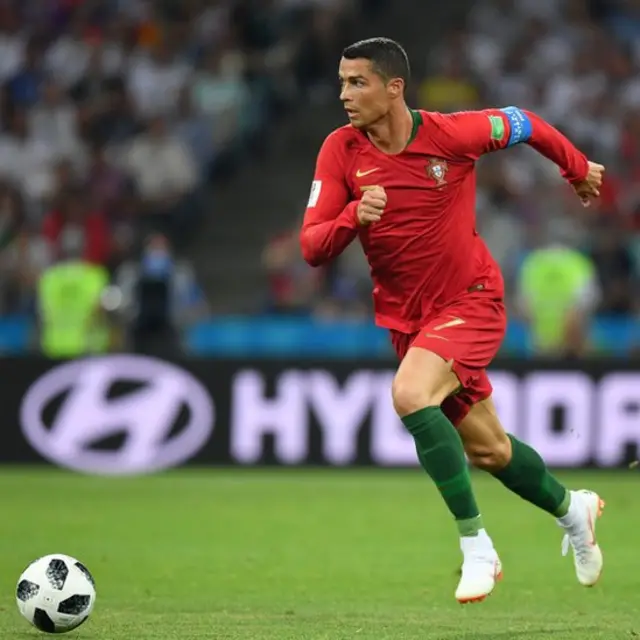

In [32]:
im = cv2.imread("datos/PoseEstimation/cristiano.png")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

inWidth  = im.shape[1]
inHeight = im.shape[0]

Image(filename="datos/PoseEstimation/cristiano.png")

## Convert Image to Blob

In [33]:
netInputSize = (368, 368)
inpBlob = cv2.dnn.blobFromImage(im, 1.0 / 255, netInputSize, (0, 0, 0), swapRB=True, crop=False)
net.setInput(inpBlob)

## Run inference (forward pass)

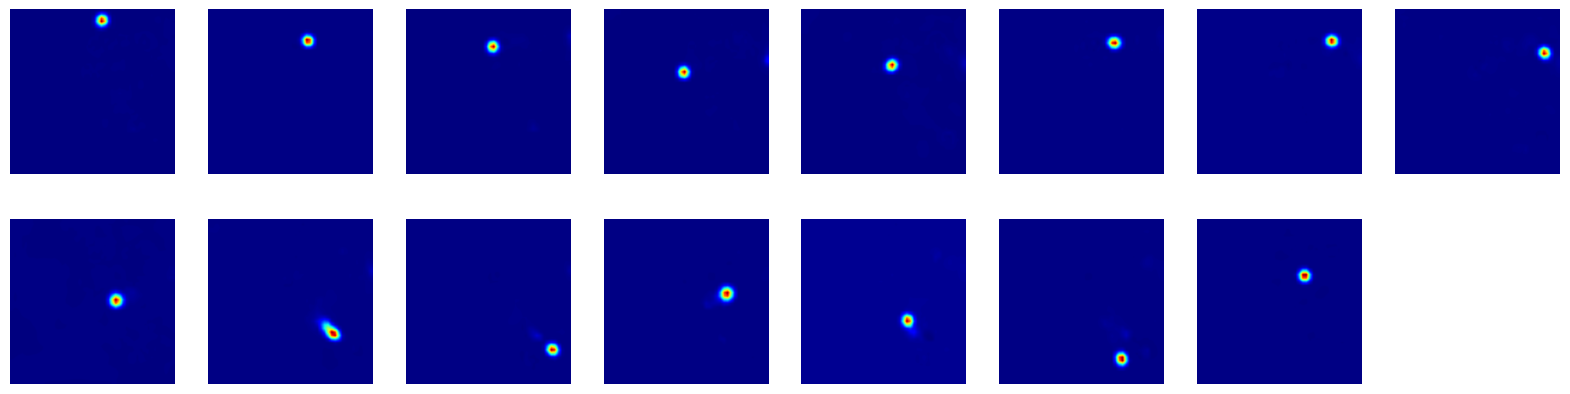

In [34]:
# Forward Pass
output = net.forward()

# Display probability maps
plt.figure(figsize=(20, 5))
for i in range(nPoints):
    probMap = output[0, i, :, :]
    displayMap = cv2.resize(probMap, (inWidth, inHeight), cv2.INTER_LINEAR)

    plt.subplot(2, 8, i + 1)
    plt.axis("off")
    plt.imshow(displayMap, cmap="jet")

## Extract Points

In [35]:
# X and Y Scale
scaleX = inWidth  / output.shape[3]
scaleY = inHeight / output.shape[2]

# Empty list to store the detected keypoints
points = []

# Treshold
threshold = 0.1

for i in range(nPoints):
    # Obtain probability map
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

    # Scale the point to fit on the original image
    x = scaleX * point[0]
    y = scaleY * point[1]

    if prob > threshold:
        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else:
        points.append(None)

## Display Points & Skeleton

In [36]:
imPoints = im.copy()
imSkeleton = im.copy()

# Draw points
for i, p in enumerate(points):
    cv2.circle(imPoints, p, 8, (255, 255, 0), thickness=-1, lineType=cv2.FILLED)
    cv2.putText(imPoints, "{}".format(i), p, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, lineType=cv2.LINE_AA)

# Draw skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(imSkeleton, points[partA], points[partB], (255, 255, 0), 2)
        cv2.circle(imSkeleton, points[partA], 8, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)

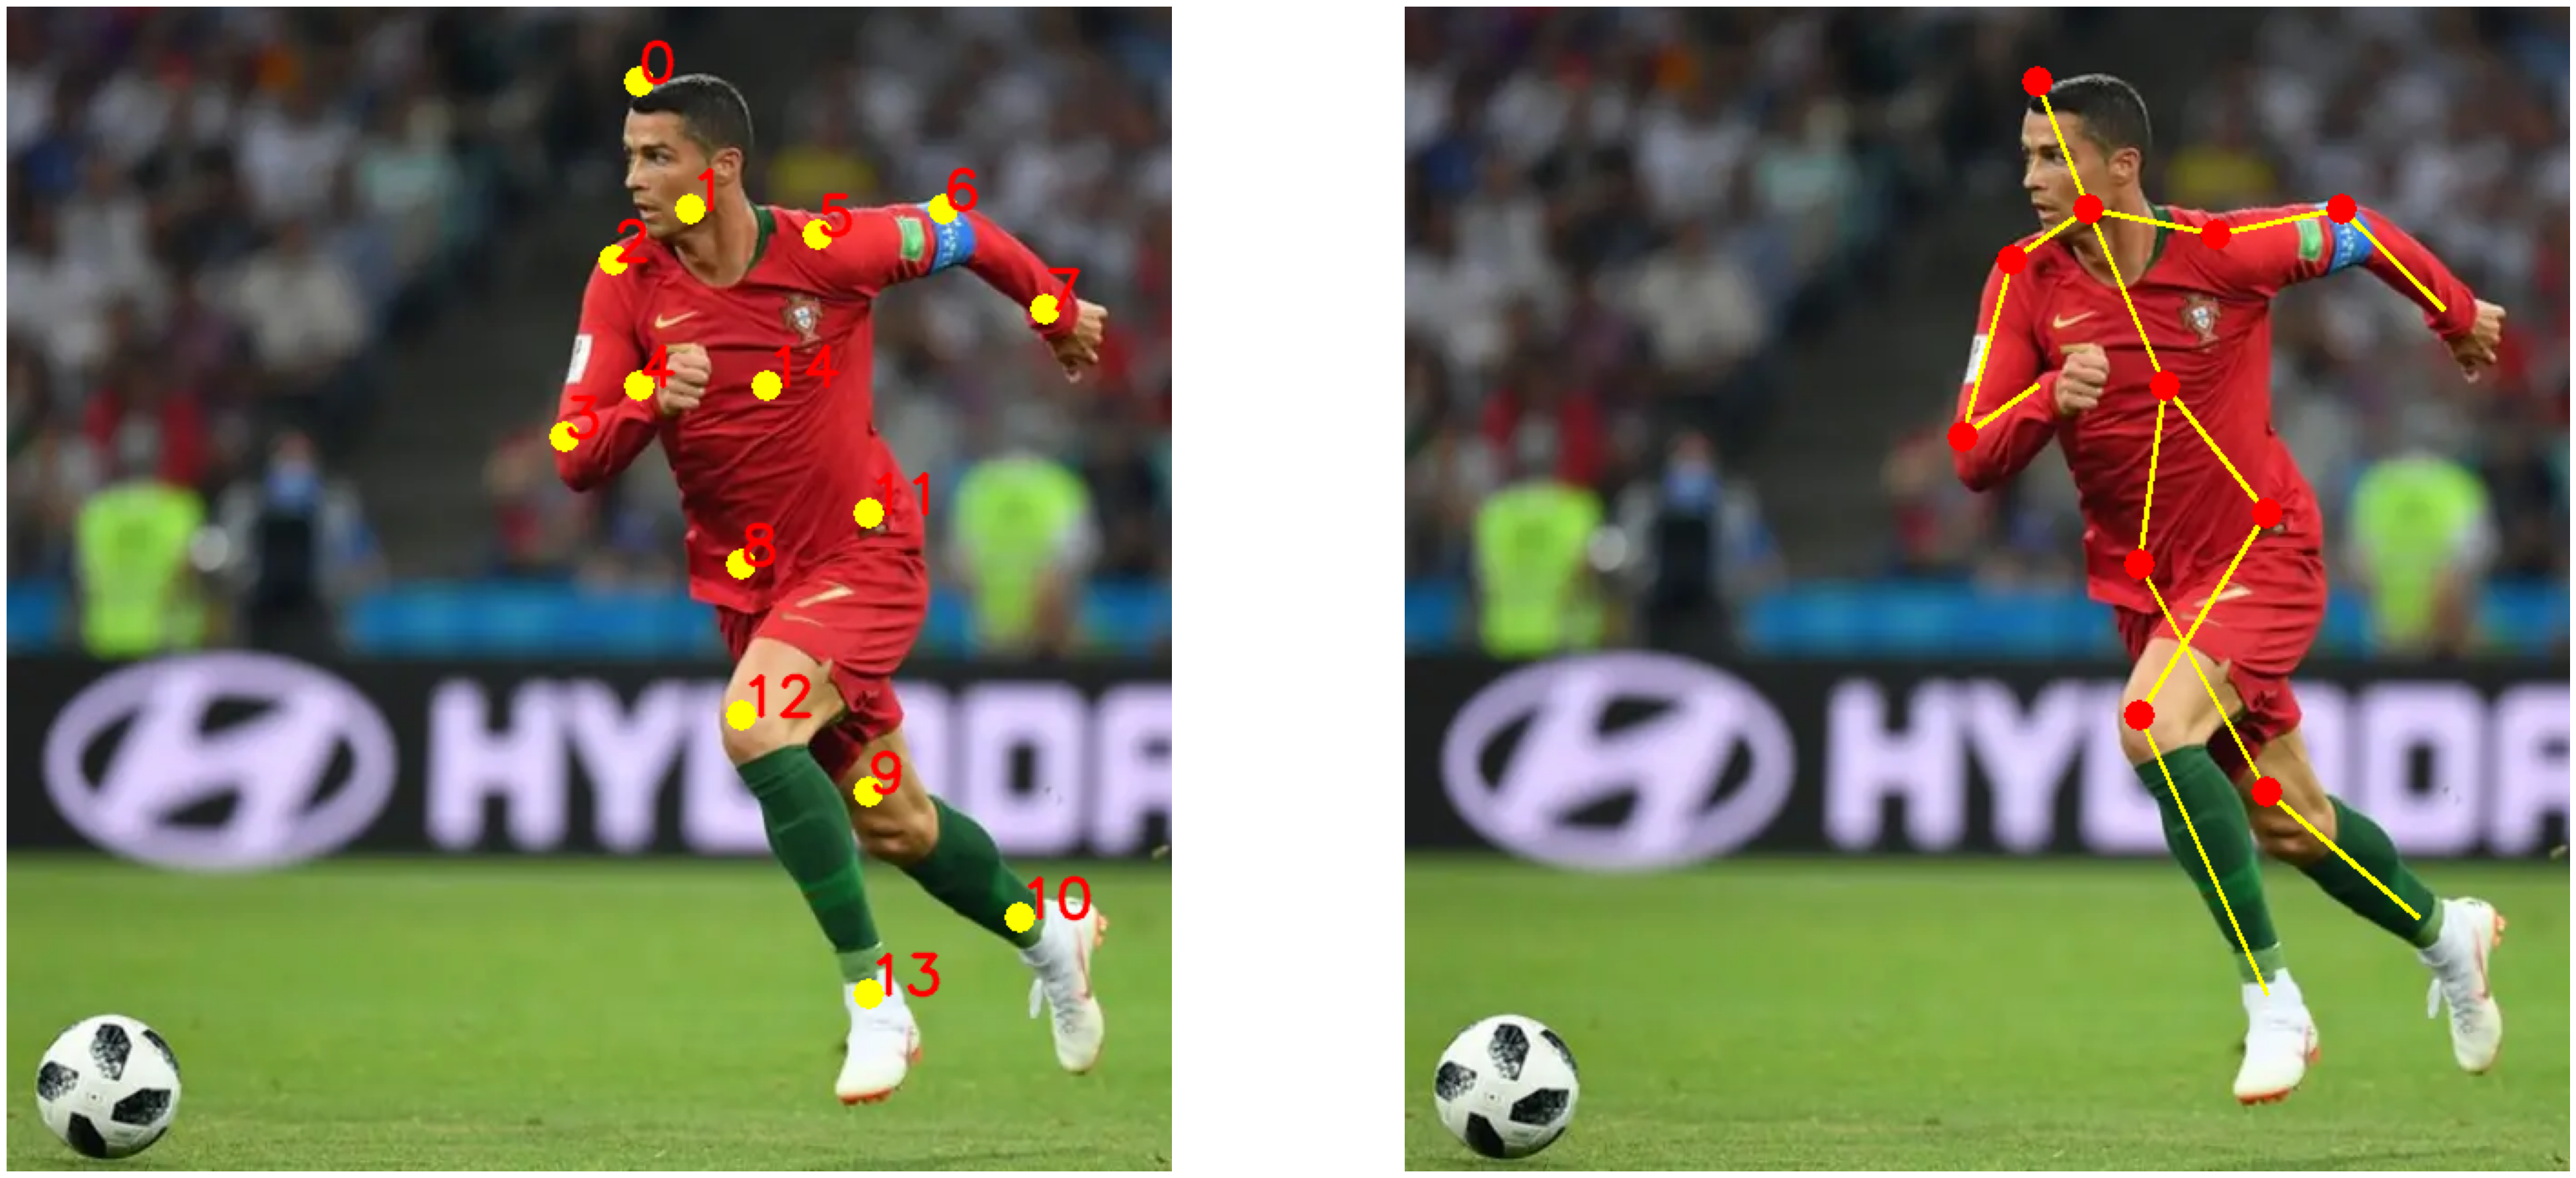

In [37]:
plt.figure(figsize=(50, 50))

plt.subplot(121)
plt.axis("off")
plt.imshow(imPoints)

plt.subplot(122)
plt.axis("off")
plt.imshow(imSkeleton)